In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [83]:
trainPath = "../data/Train.csv"
testPath = "../data/Test.csv"
metaPath = "../data/Meta.csv"

trainCSV = pd.read_csv(trainPath)
testCSV = pd.read_csv(testPath)
metaCSV = pd.read_csv(metaPath)

In [85]:
trainCSV.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [86]:
trainCSV = trainCSV[['Width', 'Height', 'ClassId', 'Path']]
testCSV = testCSV[['Width', 'Height', 'ClassId', 'Path']]
metaCSV = metaCSV[['Path', 'ClassId']]

In [87]:
pathToData = "../data/"
targetPictureSize = (32, 32)

In [88]:
def getPicturesFromDF(df):
    resized_images = []
    image_classes = []
    for index, row in df.iterrows():
        file_path = pathToData + row["Path"]  
        class_label = int(row["ClassId"])
    
        if os.path.isfile(file_path) and file_path.endswith(".png"):
            
            image = Image.open(file_path)
            
            resized_image = image.resize(targetPictureSize)
            
            transform = torchvision.transforms.Grayscale()
            tensor_image = transform(resized_image)
            transform = torchvision.transforms.ToTensor()
            tensor_image = transform(tensor_image)
            
            resized_images.append(tensor_image)
            image_classes.append(class_label)
    return resized_images, image_classes

In [96]:
resized_images = []
image_classes = []

# Iterate over the rows of the DataFrame
resized_images, image_classes = getPicturesFromDF(trainCSV)
resized_images_test, image_classes_test = getPicturesFromDF(testCSV)
resized_images.extend(resized_images_test)
image_classes.extend(image_classes_test)

tensor([[[0.5686, 0.4039, 0.3569,  ..., 0.8392, 0.8588, 0.9176],
         [0.5804, 0.4235, 0.3608,  ..., 1.0000, 1.0000, 1.0000],
         [0.7373, 0.6431, 0.6118,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7216, 0.8588, 0.9569,  ..., 1.0000, 1.0000, 1.0000],
         [0.7804, 0.8941, 0.9412,  ..., 1.0000, 1.0000, 1.0000],
         [0.8196, 0.8627, 0.9137,  ..., 1.0000, 1.0000, 1.0000]]])


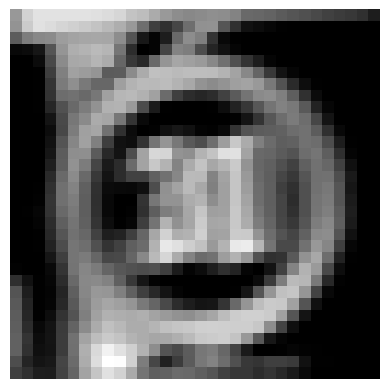

In [128]:
example_image = resized_images[1009]
print(example_image)

inverted_image = 1 - example_image

numpy_image = inverted_image.squeeze().numpy()

# Display the image using matplotlib
plt.imshow(numpy_image, cmap="gray")
plt.axis('off')
plt.show()

In [98]:
X_train, X_test, y_train, y_test = train_test_split(resized_images, image_classes, test_size=0.2, random_state=42)

In [99]:
class Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
def makeDataloader(X, y, noOfClasses = 43):
    batch_size = 32
    images_tensor = torch.stack(X)
    labels_tensor = torch.tensor(y)
    labels_tensor = F.one_hot(labels_tensor, noOfClasses)
    dataset = Dataset(images_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

trainloader = makeDataloader(X_train, y_train)
testloader = makeDataloader(X_test, y_test)

In [103]:
no_Of_Filters = 100
size_of_Filter = (5, 5)
size_of_Filter2 = (3, 3)
size_of_pool = (2, 2)
no_Of_Nodes = 300
noOfClasses = 43

OMEGA = 1.0

class NeuralNet(nn.Module):
    def __init__(self, typeNet):
        super(NeuralNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, no_Of_Filters, size_of_Filter)
        self.conv2 = nn.Conv2d(no_Of_Filters, no_Of_Filters, size_of_Filter)
        self.conv3 = nn.Conv2d(no_Of_Filters, no_Of_Filters, size_of_Filter)
        self.conv4 = nn.Conv2d(no_Of_Filters, no_Of_Filters, size_of_Filter)

        self.pool = nn.MaxPool2d(size_of_pool)

        self.fc1 = nn.Linear(no_Of_Filters * 2 * 2, no_Of_Nodes)
        self.fc2 = nn.Linear(no_Of_Nodes, noOfClasses)

        self.fc1n = nn.Linear(no_Of_Filters * 2 * 2, no_Of_Nodes)
        self.fc2n = nn.Linear(no_Of_Nodes, noOfClasses)

        self.typeNet = typeNet

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = x.view(-1, no_Of_Filters * 2 * 2)

        if self.typeNet == 'synergy':
            x1 = self.fc2(nn.ReLU()(self.fc1(x)))
            x2 = self.fc2n(nn.ReLU()(self.fc1n(x)))

            x = x1 + x2 * OMEGA
        else:
            if self.typeNet == 'hybrid':
                x = 1 - x
            x = self.fc1(x)
            x = nn.ReLU()(x)
            x = self.fc2(x)
        return x

In [105]:
normal_model = NeuralNet('normal')
device = torch.device("mps")
normal_model.to(device)

NeuralNet(
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (fc1n): Linear(in_features=400, out_features=300, bias=True)
  (fc2n): Linear(in_features=300, out_features=43, bias=True)
)

In [120]:
def trainNetwork(neuralNetwork, epochs = 10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, neuralNetwork.parameters()), lr=0.001)
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = neuralNetwork(images)
            loss = criterion(outputs, torch.argmax(labels, dim=1))

            optimizer.zero_grad()
        
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        epoch_loss = running_loss / len(trainloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

In [107]:
trainNetwork(normal_model)

Epoch [1/10], Loss: 1.0158
Epoch [2/10], Loss: 0.0834
Epoch [3/10], Loss: 0.0523
Epoch [4/10], Loss: 0.0427
Epoch [5/10], Loss: 0.0263
Epoch [6/10], Loss: 0.0265
Epoch [7/10], Loss: 0.0255
Epoch [8/10], Loss: 0.0200
Epoch [9/10], Loss: 0.0201
Epoch [10/10], Loss: 0.0194


In [73]:
torch.save(normal_model.state_dict(), "trained_model_normal.pth")

In [52]:
# Load the trained model
model = NeuralNet('normal')
model.load_state_dict(torch.load("trained_model_normal.pth"))
model.eval()
model.to(device)

RegularNN(
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (softmax): Softmax(dim=1)
)

In [111]:
def testNetwork(neuralNetwork):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = neuralNetwork(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, dim=1)).sum().item()
    print(f"Accuracy of the network on the {total} test images: %.2f%%" % (100 * correct / total))

In [149]:
def getConfusionMatrix(neuralNetwork):
    confusion_matrix = torch.zeros(noOfClasses, noOfClasses)
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = neuralNetwork(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(len(labels)):
                confusion_matrix[torch.argmax(labels[i])][predicted[i]] += 1
    return confusion_matrix

def showConfusionMatrix(cm):
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [112]:
testNetwork(normal_model)

Accuracy of the network on the 10368 test images: 99.06%


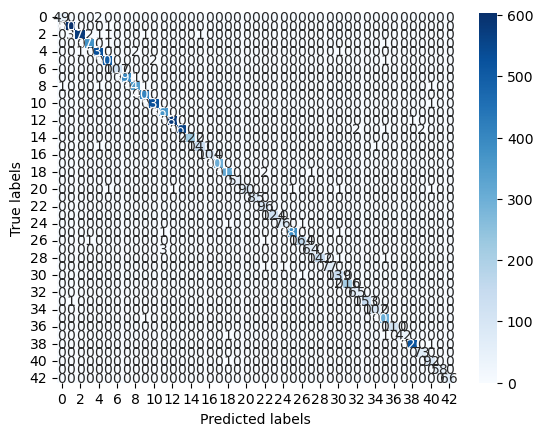

In [150]:
showConfusionMatrix(getConfusionMatrix(normal_model))

In [129]:
hybrid_model = NeuralNet('hybrid')
hybrid_model.conv1 = normal_model.conv1
hybrid_model.conv2 = normal_model.conv2
hybrid_model.conv3 = normal_model.conv3
hybrid_model.conv4 = normal_model.conv4
hybrid_model.conv1.weight.requires_grad = False
hybrid_model.conv2.weight.requires_grad = False
hybrid_model.conv3.weight.requires_grad = False
hybrid_model.conv4.weight.requires_grad = False

hybrid_model.to(device)

NeuralNet(
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (fc1n): Linear(in_features=400, out_features=300, bias=True)
  (fc2n): Linear(in_features=300, out_features=43, bias=True)
)

In [130]:
trainNetwork(hybrid_model)

Epoch [1/10], Loss: 0.0733
Epoch [2/10], Loss: 0.0174
Epoch [3/10], Loss: 0.0150
Epoch [4/10], Loss: 0.0086
Epoch [5/10], Loss: 0.0127
Epoch [6/10], Loss: 0.0118
Epoch [7/10], Loss: 0.0091
Epoch [8/10], Loss: 0.0086
Epoch [9/10], Loss: 0.0085
Epoch [10/10], Loss: 0.0074


In [131]:
testNetwork(hybrid_model)

Accuracy of the network on the 10368 test images: 99.34%


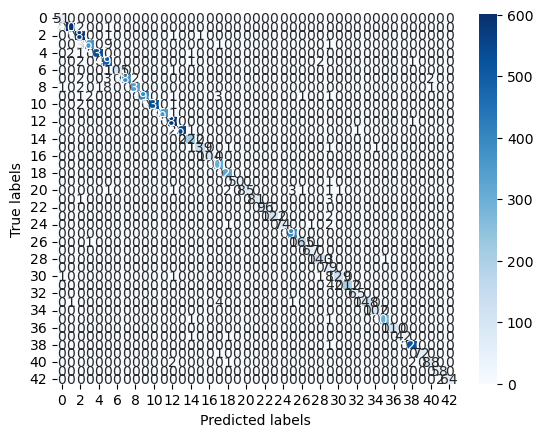

In [151]:
showConfusionMatrix(getConfusionMatrix(hybrid_model))

In [132]:
torch.save(hybrid_model.state_dict(), "trained_model_hybrid.pth")

In [133]:
synergy_model = NeuralNet('synergy')
synergy_model.conv1 = hybrid_model.conv1
synergy_model.conv2 = hybrid_model.conv2
synergy_model.conv3 = hybrid_model.conv3
synergy_model.conv4 = hybrid_model.conv4
synergy_model.conv1.weight.requires_grad = False
synergy_model.conv2.weight.requires_grad = False
synergy_model.conv3.weight.requires_grad = False
synergy_model.conv4.weight.requires_grad = False
synergy_model.fc1 = normal_model.fc1
synergy_model.fc2 = normal_model.fc2
synergy_model.fc1n = hybrid_model.fc1n
synergy_model.fc2n = hybrid_model.fc2n
synergy_model.to(device)

NeuralNet(
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(100, 100, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=43, bias=True)
  (fc1n): Linear(in_features=400, out_features=300, bias=True)
  (fc2n): Linear(in_features=300, out_features=43, bias=True)
)

In [134]:
trainNetwork(synergy_model)

Epoch [1/10], Loss: 0.0084
Epoch [2/10], Loss: 0.0055
Epoch [3/10], Loss: 0.0043
Epoch [4/10], Loss: 0.0034
Epoch [5/10], Loss: 0.0084
Epoch [6/10], Loss: 0.0022
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0001
Epoch [9/10], Loss: 0.0062
Epoch [10/10], Loss: 0.0062


In [135]:
testNetwork(synergy_model)

Accuracy of the network on the 10368 test images: 99.37%


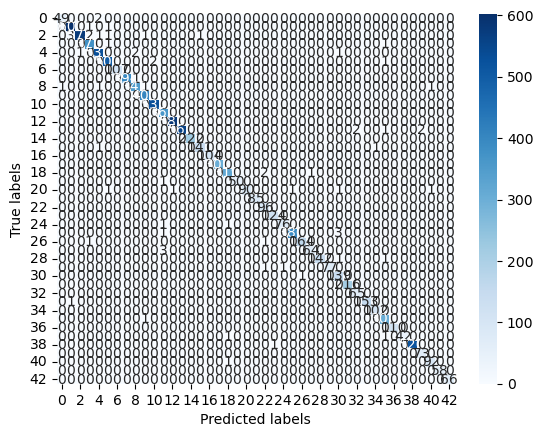

In [152]:
showConfusionMatrix(getConfusionMatrix(synergy_model))

In [136]:
torch.save(synergy_model.state_dict(), "trained_model_synergy.pth")